## Business Context

Startup XYZ is receiving many applications for job positions. They don't have a HR team for now, as the boss is the one who is taking charges of the hiring. In order to save time and make the best hiring decision, he assigned me, the data scientist of the company, to build a deep learning model in order to screen out candidates.

Please find the link to the dataset:

https://www.kaggle.com/datasets/rabieelkharoua/predicting-hiring-decisions-in-recruitment-data

## 1. Importing Necessary Libraries

In [35]:
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from keras import Sequential
from sklearn.model_selection import train_test_split
import numpy as np
import time
from keras.layers import Dense
from matplotlib import pyplot as plt
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

## 2. Data Acquisition

We upload, in the following cell, our dataset

In [29]:
uploaded_file = files.upload()
uploaded_file = list(uploaded_file.keys())[0]
rec_data = pd.read_csv(uploaded_file)

Saving recruitment_data.csv to recruitment_data (1).csv


## 3. Data Exploration

Let's split our dataset to avoid data leakage, then we start exploring it

In [30]:
rec_data_train, rec_data_test = train_test_split(rec_data, test_size = 0.2, stratify= rec_data['HiringDecision'], random_state = 35)

In [79]:
rec_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 1364 to 772
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1200 non-null   int64  
 1   Gender               1200 non-null   int64  
 2   EducationLevel       1200 non-null   int64  
 3   ExperienceYears      1200 non-null   int64  
 4   PreviousCompanies    1200 non-null   int64  
 5   DistanceFromCompany  1200 non-null   float64
 6   InterviewScore       1200 non-null   int64  
 7   SkillScore           1200 non-null   int64  
 8   PersonalityScore     1200 non-null   int64  
 9   RecruitmentStrategy  1200 non-null   int64  
 10  HiringDecision       1200 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 112.5 KB


The dataset has 10 features and they are all numeric. The target variable is 'HiringDecision' and it is numeric as well.

In [15]:
rec_data.describe()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,35.148667,0.492000,2.188000,7.694000,3.00200,25.505379,50.564000,51.116000,49.387333,1.893333,0.310000
std,9.252728,0.500103,0.862449,4.641414,1.41067,14.567151,28.626215,29.353563,29.353201,0.689642,0.462647
min,20.000000,0.000000,1.000000,0.000000,1.00000,1.031376,0.000000,0.000000,0.000000,1.000000,0.000000
25%,27.000000,0.000000,2.000000,4.000000,2.00000,12.838851,25.000000,25.750000,23.000000,1.000000,0.000000
50%,35.000000,0.000000,2.000000,8.000000,3.00000,25.502239,52.000000,53.000000,49.000000,2.000000,0.000000
75%,43.000000,1.000000,3.000000,12.000000,4.00000,37.737996,75.000000,76.000000,76.000000,2.000000,1.000000
max,50.000000,1.000000,4.000000,15.000000,5.00000,50.992462,100.000000,100.000000,100.000000,3.000000,1.000000


Based on the dataset description, the columns 'Gender' and 'HiringDecision' are binary and the others are not

In [17]:
rec_data_train.isnull().sum()

Age                    0
Gender                 0
EducationLevel         0
ExperienceYears        0
PreviousCompanies      0
DistanceFromCompany    0
InterviewScore         0
SkillScore             0
PersonalityScore       0
RecruitmentStrategy    0
HiringDecision         0
dtype: int64

Our dataset doesn't have any missing values

## 4. Data Preprocessing

We handle in the following cell, the outliers in our dataset

In [7]:
for i in rec_data_train:
  Q1 = rec_data_train[i].quantile(0.25)
  Q3 = rec_data_train[i].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  rec_data_train[i] = np.where(rec_data_train[i] < lower_bound, lower_bound, rec_data_train[i])
  rec_data_train[i] = np.where(rec_data_train[i] > upper_bound, upper_bound, rec_data_train[i])
  rec_data_test[i] = np.where(rec_data_test[i] < lower_bound, lower_bound, rec_data_test[i])
  rec_data_test[i] = np.where(rec_data_test[i] > upper_bound, upper_bound, rec_data_test[i])

## 5. Data Visualization

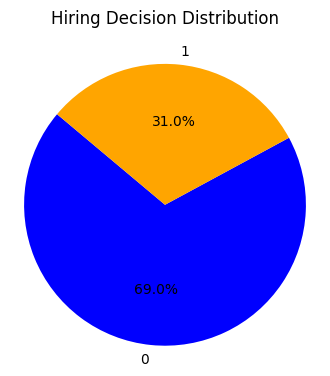

In [24]:
# Count the occurrences of each HiringDecision category
hiring_counts = rec_data['HiringDecision'].value_counts()
# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(hiring_counts, labels=hiring_counts.index, autopct='%1.1f%%', startangle=140, colors=['blue', 'orange'])
plt.title('Hiring Decision Distribution', pad = 20)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.show()

The pie chart shows that 69% of the candidates are not hired. Thus, we need to balance out our dataset

In [53]:
from imblearn.over_sampling import RandomOverSampler
X = rec_data_train.drop('HiringDecision', axis=1)
y = rec_data_train['HiringDecision']
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
rec_data_train_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['HiringDecision'])], axis=1)

## 6. Scaling Features

In [47]:
X_train = rec_data_train.drop('HiringDecision', axis = 1)
y_train = rec_data_train['HiringDecision']
X_test  = rec_data_test.drop('HiringDecision', axis = 1)
y_test = rec_data_test['HiringDecision']

In [48]:
scaling = StandardScaler()
scaling.fit(X_train)
X_train_encoded = scaling.transform(X_train)
X_test_encoded  = scaling.transform(X_test)

X_train = pd.DataFrame(X_train_encoded, columns=X_train.columns)
X_test = pd.DataFrame(X_test_encoded, columns=X_test.columns)

## 7. Dimension Reduction using PCA

In [45]:
pca = PCA(n_components=6)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [46]:
print(pca.explained_variance_ratio_)

[0.11502649 0.1080648  0.1063434  0.10459845 0.10191086 0.09716338]


In [54]:
X_train = pd.DataFrame(data=X_train, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
X_test = pd.DataFrame(data=X_test, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

## 8 Computational experimentation

After splitting the dataset into training and validation datasets, we try various configurations of hyperparameters and preprocessing steps and in the end we select the best configuration to run it on the test set.

In [49]:
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size = 0.10, random_state =35)

In [6]:
import pandas as pd


In [4]:
l1 = 'yes;Oversampling;yes;yes;3;linear;D;32;adam;65,00%;3,10'.split(';')
l2 = 'yes;Oversampling;yes;yes;3;linear;D;32;sgd;65,00%;2,30'.split(';')
l3 = 'yes;Oversampling;yes;yes;3;linear;D;64;sgd;65,00%;2,10'.split(';')
l4 = 'yes;Oversampling;yes;yes;3;linear;D;1;sgd;66,70%;41,7'.split(';')
l5 = 'yes;Oversampling;yes;yes;3;linear;D;64;sgd;65,00%;2,03'.split(';')
l6 = 'yes;Oversampling;yes;yes;3;tanh;D+2;64;sgd;65,00%;2,07'.split(';')
l7 = 'yes;Oversampling;yes;yes;2;linear;D;64;sgd;47,50%;2,03'.split(';')
l8 = 'yes;Oversampling;yes;no;2;linear;D;64;sgd;66,70%;1,79'.split(';')
l9='yes;Oversampling;no;no;2;linear;D;64;sgd;69,50%;1,74'.split(';')
l10='yes;Oversampling;no;no;2;linear;D;64;sgd;56,12%;1,63'.split(';')
l11='no;class weight adjustment;yes;no;2;linear;D;64;sgd;82,50%;1,43'.split(';')

In [9]:
cols ='Remove outliers;Balance out dataset;Scaling;PCA;Number of layers;First Activation Function;Number of neurons(layer 1);Batch size;Optimizer;Score;Execution time'.split(';')

In [10]:
results = [
    l1,
    l2,
    l3,
    l4,
    l5,
    l6,
    l7,
    l8,
    l9,
    l10,
    l11]
results = pd.DataFrame(results, columns = cols)

In [11]:
results

,Remove outliers,Balance out dataset,Scaling,PCA,Number of layers,First Activation Function,Number of neurons(layer 1),Batch size,Optimizer,Score,Execution time
0,yes,Oversampling,yes,yes,3,linear,D,32,adam,"65,00%","3,10"
1,yes,Oversampling,yes,yes,3,linear,D,32,sgd,"65,00%","2,30"
2,yes,Oversampling,yes,yes,3,linear,D,64,sgd,"65,00%","2,10"
3,yes,Oversampling,yes,yes,3,linear,D,1,sgd,"66,70%","41,7"
4,yes,Oversampling,yes,yes,3,linear,D,64,sgd,"65,00%","2,03"
5,yes,Oversampling,yes,yes,3,tanh,D+2,64,sgd,"65,00%","2,07"
6,yes,Oversampling,yes,yes,2,linear,D,64,sgd,"47,50%","2,03"
7,yes,Oversampling,yes,no,2,linear,D,64,sgd,"66,70%","1,79"
8,yes,Oversampling,no,no,2,linear,D,64,sgd,"69,50%","1,74"
9,yes,Oversampling,no,no,2,linear,D,64,sgd,"56,12%","1,63"


## 9. Final Model

In [50]:
target_weights = compute_class_weight(class_weight='balanced', classes = [0, 1], y=y_train)
target_weights_dict = dict(enumerate(target_weights))

model = Sequential([
Dense(10, input_shape = (10,), activation = 'linear'),
#Dense(2, activation = 'tanh'),
Dense(1, activation = 'sigmoid')
    ])
model.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
start = time.time()
model.fit(X_train, y_train, epochs = 10, batch_size = 64, validation_data = (X_val, y_val), class_weight=target_weights_dict)
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

finish = time.time()
running_time = finish - start

print('Classification report: ')
print(classification_report(y_test, y_pred))
print('Running time: ', running_time)

Epoch 1/10
17/17 [==============================] - 1s 12ms/step - loss: 0.7299 - accuracy: 0.5602 - val_loss: 0.6631 - val_accuracy: 0.6583
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.5926 - val_loss: 0.6159 - val_accuracy: 0.6917
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 0.6353 - accuracy: 0.6176 - val_loss: 0.5773 - val_accuracy: 0.7000
Epoch 4/10
17/17 [==============================] - 0s 4ms/step - loss: 0.6011 - accuracy: 0.6435 - val_loss: 0.5453 - val_accuracy: 0.7250
Epoch 5/10
17/17 [==============================] - 0s 4ms/step - loss: 0.5728 - accuracy: 0.6713 - val_loss: 0.5187 - val_accuracy: 0.7500
Epoch 6/10
17/17 [==============================] - 0s 4ms/step - loss: 0.5494 - accuracy: 0.6870 - val_loss: 0.4963 - val_accuracy: 0.7583
Epoch 7/10
17/17 [==============================] - 0s 4ms/step - loss: 0.5301 - accuracy: 0.7148 - val_loss: 0.4773 - val_accuracy: 0.7583
Epoch 8/10
17/17 [=

## 10. Conclusion:

In this work, we built a model to automate the hiring process by experimenting with different preprocessing steps, and different hyperparameters. The last experimentation gave the best accuracy score. We tried to prioritize the accuracy while making sure the precision and recall for both classes remain above 50%. The final accuracy score was 75% on the test set. The precision and recall for both classes are above 50%.

## 11. Limitations of the pipeline:

The main limitation of the pipeline is the fact that we are trying heuristic ways to find the best configuration of our pipeline, due to the complexity of the problem. Nevertheless, the performance that we achieve can still help the startup and improve its hiring process.